# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__
1) Which living outcome do housing conditions affect the most (education, health or happiness)?

2) Is there a correlation between precarious housing and health (both physical and mental) status?

3) In what ways do living conditions affect children scholarship (if they do) ? Which age group is most impacted ?


## Data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from math import exp, log
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta',convert_categoricals=False)
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta',convert_categoricals=False)

In [3]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','RESPID','UCPSID','SEX','UAGE','SITE','STATE','UREGION','TYPEINT','HHID']
household_id_hh = ['HHID']
#education = ['CCHGSC','CSUEXP','CATTSC','CSKIPSC','CGETBY','CHMWK','CINTSC','CWRKSC','UENG','UENGNEG','UENGPOS']
education = ['UENG','UENGNEG','UENGPOS','NLESSONS']
#family = ['GHMAD','GSELFHR','UFAMSTR','UMH2','UMHIGDEG']
family = ['UFAMSTR','UMH2','UMHIGDEG','UAGG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT'] #'OVERCROWDING' added later on
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS']
health = ['BDISBL','BHLTHN','FDOCT','FWHMED','FWHYMED','FDENT','FWELLV','UCNGHL']
activities = ['NOUTING','NSPORTS','UOUTNEG','UOUTPOS','UACT','UACTNEG','UACTPOS']
programs = ['GCENTR','CSPECED','CAGRAD','GHEADS','KAPPMED','SSHELP']
programs_hh = ['MPUBHOUS']
eco = ['CJOB','UHINS4'] #NB CJOB only for fc3

# Add a variable 'overcrowding' and replace inf by -1
hh['OVERCROWDING'] = hh['UHHCOUNT'] / hh['MNBEDRMS']
housing_hh.append('OVERCROWDING')
hh['OVERCROWDING'] = hh['OVERCROWDING'].apply(lambda x : -1 if (x == np.inf or x < 0) else x)

# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + programs + eco]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh + programs_hh]

In [4]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')

# NaNs handling : replace all the missing values by -1
child.replace([-7,-8,-9],-1,inplace=True)

# Make the SEX variable binary with F=1 and M=0
child['SEX'].replace(to_replace=dict(F=1, M=0),inplace=True)
# Make the CJOB variable binary with Yes=1 and No=0
child['CJOB'].replace(2,0,inplace=True)

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,RESPID,UCPSID,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,...,CJOB,UHINS4,CHLD0_5,CHLD6_17,UHHCOUNT,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,MPUBHOUS
0,5561612801,1,5561612803,5561612800,1,3,15,WI,2,A1,...,-1,2,2,0,3,1,4,1,0.75,-1
1,5470400001,2,5470400003,5470400000,0,14,15,WI,2,A1,...,0,1,0,2,3,2,2,2,1.50,-1
2,5787427204,2,5787427205,5787427200,1,9,15,WI,2,A1,...,-1,2,0,4,6,1,3,2,2.00,2
3,5410681601,1,5410681604,5410681600,0,4,15,WI,2,A1,...,-1,2,3,0,5,1,2,2,2.50,2
4,5051721601,2,5051721605,5051721600,1,17,15,WI,2,A1,...,1,2,0,4,5,1,4,2,1.25,1


In [5]:
# Divide child data in 4 dfs based on age groups

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin([1,2])]

# are there young children (0-5yo) in household?
child.loc[:,'bool0_5'] = child['CHLD0_5'].apply(lambda x : 0 if x == 0 else 1)

# FC1 : focal child, aged 0-5
fc1 = child.copy()[child['PERSTYPE']==1]

# FC23 : focal child, aged 6-17
fc23 = child.copy()[child['PERSTYPE']==2]

# FC2 : focal child, aged 6-11
fc2 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] < 12)]

# FC3 : focal child, aged 12-17
fc3 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] >= 12)]

In [6]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}\nfc23: {fc23.shape}')
print((fc1.shape[0] + fc2.shape[0] + fc3.shape[0]) == child.shape[0]) #test to see if all children are counted

Shapes of dataframes:
fc1: (12268, 58)
fc2: (10925, 58)
fc3:(11087, 58)
fc23: (22012, 58)
True


## Propensity score attempt

__Living conditions indicator :__

In [7]:
# returns a dataframe where the rows of the given 'df' containing NaN values for either the 'outcome'
# or any of the 'predictors' have been removed
def df_NN(df,outcome,predictors):
    if len(predictors) <= 1:
        bools = (df[predictors[0]] != -1)
    else:
        bools = df[predictors].isin([-1]).any(axis=1)==False
    
    return df.loc[(df[outcome] != -1) & (bools)]

In [8]:
# Variables used for precarity indicator (economics and relationship with family)
# NB CHOICE OF WORDS : PRECARITY NOT VERY ACCURATE
prec = ['U_SOCPOV','OVERCROWDING','MOWNRENT','UHINS4','UAGG','UFAMSTR']
prec3 = prec + ['CJOB']

# IL FAUDRA DECIDER DE COMMENT GERER LES NANS SUR CES VALEURS POUR DEFINIR L'INDEX

df_prec_2 = df_NN(fc2,'PERSID',prec)
df_prec_3 = df_NN(fc3,'PERSID',prec3)

In [9]:
# Living conditions indicator
negative = ['OVERCROWDING','MOWNRENT','UHINS4']
negative3 = negative + ['CJOB']
positive = ['U_SOCPOV','UAGG','UFAMSTR']
    
# Normalize all the variables and sign them -> WE CAN CHOOSE WEIGHTS LATER TO TUNE THE INDEX
# NB performs column-wise automatically
norm_prec_2 =(df_prec_2[prec]-df_prec_2[prec].min())/(df_prec_2[prec].max()-df_prec_2[prec].min())
norm_prec_3 =(df_prec_3[prec3]-df_prec_3[prec3].min())/(df_prec_3[prec3].max()-df_prec_3[prec3].min())
norm_prec_2.loc[:,negative] *= -1
norm_prec_3.loc[:,negative3] *= -1

# Compute living conditions indicator
norm_prec_2.loc[:,'living_ind'] = norm_prec_2.sum(axis=1)
norm_prec_3.loc[:,'living_ind'] = norm_prec_3.sum(axis=1)

In [10]:
# Choose a threshold to consider a household 'precarious' or not -> ADAPT (j'ai juste pris zero en mode random)
norm_prec_2.loc[:,'precarious'] = norm_prec_2['living_ind'].apply(lambda x : 0 if x < 1 else 1)
norm_prec_3.loc[:,'precarious'] = norm_prec_3['living_ind'].apply(lambda x : 0 if x < 1 else 1)

# Merge this new column with whole df without NaNs
fc2_prec = pd.merge(fc2, norm_prec_2['precarious'], left_index=True, right_index=True, how='inner')
fc3_prec = pd.merge(fc3, norm_prec_3['precarious'], left_index=True, right_index=True, how='inner')

In [11]:
fc2_prec.head()

,PERSID,PERSTYPE,RESPID,UCPSID,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,...,CHLD0_5,CHLD6_17,UHHCOUNT,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,MPUBHOUS,bool0_5,precarious
2,5787427204,2,5787427205,5787427200,1,9,15,WI,2,A1,...,0,4,6,1,3,2,2.000000,2,0,0
6,5353539201,2,5353539204,5353539200,1,11,15,WI,2,A1,...,2,1,9,2,4,2,2.250000,2,1,0
13,5442400001,2,5442400007,5442400000,0,11,15,WI,2,A1,...,3,3,8,1,3,2,2.666667,2,1,0
21,5851446401,2,5851446402,5851446400,0,7,15,WI,2,A1,...,0,1,2,1,2,2,1.000000,2,0,0
22,5047936001,2,5047936005,5047936000,1,8,15,WI,2,A1,...,3,1,5,1,3,2,1.666667,2,1,0


__Logistic regression and propensity score :__

In [12]:
# Perform logistic regression

log_model_2 = 'precarious ~ SEX + UAGE + UREGION + UENG + UFAMSTR + UMH2 + UMHIGDEG + UAGG + CHLD0_5 + CHLD6_17 \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + UBPIA + BDISBL + BHLTHN + UACT + CSPECED + UHINS4'

log_model_3 = 'precarious ~ SEX + UAGE + UREGION + UENG + UFAMSTR + UMH2 + UMHIGDEG + UAGG + CHLD0_5 + CHLD6_17 \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + UBPIB + BDISBL + BHLTHN + UACT + CSPECED + UHINS4 \
+ C(CJOB)'

log2 = smf.logit(formula=log_model_2, data=fc2_prec)
res2 = log2.fit(method='bfgs')  #J'AI MIS CETTE METHODE RANDOM PCQ SINON ÇA COMPILAIT PAS MAIS JSP CE QUE C'EST
log3 = smf.logit(formula=log_model_3, data=fc3_prec)
res3 = log3.fit(method='bfgs')

         Current function value: 0.035509
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


C:\Users\alanh\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.046458
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


C:\Users\alanh\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             precarious   No. Observations:                10665
Model:                          Logit   Df Residuals:                    10641
Method:                           MLE   Df Model:                           23
Date:                Fri, 04 Dec 2020   Pseudo R-squ.:                  0.9333
Time:                        13:16:30   Log-Likelihood:                -378.70
converged:                      False   LL-Null:                       -5674.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.3849      1.283     -1.080      0.280      -3.899       1.129
UREGION[T.2]     0.0366      0.290      0.126      0.900      -0.533       0.606
UREGION[T.3]     0.0609      0.270      0.226      0.821      -0.467       0.589
UREGION[T.4]    -0.3420      0.288     -1.186      0.236      -0.907       0.223
SEX             -0.0861      0.185     -0.465      0.642      -0.449       0.277
UAGE            -0.4268      0.061     -6.952      0.000      -0.547      -0.306
UENG            -0.0705      0.036     -1.984      0.047      -0.140      -0.001
UFAMSTR          7.8713      0.409     19.268      0.000       7.071       8.672
UMH2            -0.0020      0.006     -0.304      0.761      -0.015       0.011
UMHIGDEG        -0.1400      0.045     -3.114      0.002      -0.228      -0.052
UAGG             1.5878      0.096     16.596      0.000       1.400       1.775
CHLD0_5         -0.5884      0.179     -3.283      0.001      -0.940      -0.237
CHLD6_17        -0.4208      0.158     -2.669      0.008      -0.730      -0.112
UHHCOUNT         0.1505      0.168      0.897      0.370      -0.178       0.479
U_SOCPOV         6.1704      0.324     19.062      0.000       5.536       6.805
MNBEDRMS        -0.0658      0.221     -0.297      0.766      -0.500       0.368
MOWNRENT       -11.9452      0.623    -19.158      0.000     -13.167     -10.723
OVERCROWDING    -2.5715      0.324     -7.927      0.000      -3.207      -1.936
UBPIA           -0.2826      0.052     -5.475      0.000      -0.384      -0.181
BDISBL          -0.8962      0.320     -2.800      0.005      -1.524      -0.269
BHLTHN          -0.5258      0.105     -5.020      0.000      -0.731      -0.321
UACT             0.0303      0.103      0.293      0.769      -0.172       0.232
CSPECED         -0.7670      0.224     -3.421      0.001      -1.206      -0.328
UHINS4          -7.9918      0.414    -19.288      0.000      -8.804      -7.180
================================================================================

Possibly complete quasi-separation: A fraction 0.80 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [14]:
diff2 = (res2.predict(fc2_prec) - fc2_prec['precarious'])
fc2_prec.loc[:,'predict_precarious'] = res2.predict(fc2_prec)
print('RES2 :  mean error : '+ str(diff2.mean())+',  std : '+ str(diff2.std()))

RES2 :  mean error : -1.1292419443499894e-05,  std : 0.10503502399711755


In [15]:
diff3 = (res3.predict(fc3_prec) - fc3_prec['precarious'])
fc3_prec.loc[:,'predict_precarious'] = res3.predict(fc3_prec)
print('RES3 :  mean error : '+ str(diff3.mean())+',  std : '+ str(diff3.std()))

RES3 :  mean error : 0.004162385380685083,  std : 0.12044303710942893


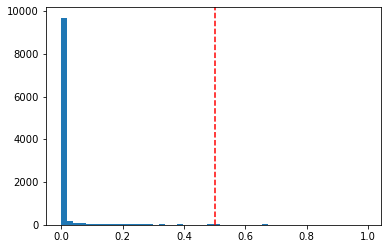

In [16]:
plt.hist(abs(diff2),bins=50)
plt.axvline(0.5,color='r',linestyle='--')
plt.show()

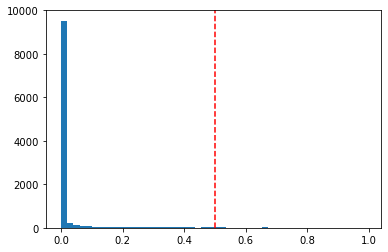

In [17]:
plt.hist(abs(diff3),bins=50)
plt.axvline(0.5,color='r',linestyle='--')
plt.show()

### PS for bool0_5

In [18]:
# je retrouve exclusivement les rows avec PERSTYPE = 2, surement une variable que je sélectionne qui était seulement demandées aux 6-17

In [19]:
# logistic regression for CHLD0_5
predictors= ['SEX','UAGE','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','CHLD6_17','UHHCOUNT','U_SOCPOV','MNBEDRMS','MOWNRENT','OVERCROWDING','UBPIA','BDISBL','BHLTHN','UACT','CSPECED','UHINS4']
df_05 = df_NN(child,'bool0_5',predictors)

log_model_1 = 'bool0_5 ~ SEX + UAGE + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG + CHLD6_17 \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + UBPIA + BDISBL + BHLTHN + UACT + CSPECED + UHINS4'

log1 = smf.logit(formula=log_model_1, data=df_05)
res1 = log1.fit()

Optimization terminated successfully.
         Current function value: 0.373439
         Iterations 7


In [20]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                bool0_5   No. Observations:                10501
Model:                          Logit   Df Residuals:                    10479
Method:                           MLE   Df Model:                           21
Date:                Fri, 04 Dec 2020   Pseudo R-squ.:                  0.4511
Time:                        13:16:32   Log-Likelihood:                -3921.5
converged:                       True   LL-Null:                       -7143.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.2723      0.458     -2.778      0.005      -2.170      -0.375
UREGION[T.2]     0.2230      0.082      2.717      0.007       0.062       0.384
UREGION[T.3]    -0.0298      0.084     -0.354      0.723      -0.194       0.135
UREGION[T.4]     0.0843      0.086      0.976      0.329      -0.085       0.254
SEX              0.0318      0.058      0.552      0.581      -0.081       0.145
UAGE            -0.2457      0.017    -14.161      0.000      -0.280      -0.212
UFAMSTR         -0.1448      0.035     -4.144      0.000      -0.213      -0.076
UMH2             0.0048      0.002      1.987      0.047    6.65e-05       0.010
UMHIGDEG        -0.0035      0.016     -0.225      0.822      -0.034       0.027
UAGG            -0.0926      0.018     -5.215      0.000      -0.127      -0.058
CHLD6_17        -2.7777      0.060    -46.352      0.000      -2.895      -2.660
UHHCOUNT         2.3701      0.063     37.914      0.000       2.248       2.493
U_SOCPOV        -0.4298      0.031    -13.885      0.000      -0.490      -0.369
MNBEDRMS        -0.1047      0.065     -1.604      0.109      -0.233       0.023
MOWNRENT         0.3884      0.065      5.989      0.000       0.261       0.516
OVERCROWDING     0.0059      0.110      0.053      0.957      -0.210       0.222
UBPIA           -0.0139      0.017     -0.816      0.415      -0.047       0.020
BDISBL           0.0681      0.111      0.612      0.541      -0.150       0.286
BHLTHN          -0.1370      0.036     -3.826      0.000      -0.207      -0.067
UACT             0.1011      0.033      3.090      0.002       0.037       0.165
CSPECED          0.1690      0.098      1.725      0.085      -0.023       0.361
UHINS4          -0.1414      0.035     -4.024      0.000      -0.210      -0.073
================================================================================
"""

In [21]:
pred1 = res1.predict(df_05)
diff1 = (pred1 - df_05['bool0_5'])
df_05.loc[:,'PS'] = pred1
print('RES1 :  mean error : '+ str(diff1.mean())+',  std : '+ str(diff1.std()))

RES1 :  mean error : 1.509462174020615e-16,  std : 0.3304809144688764


C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


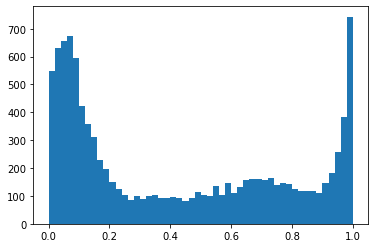

In [22]:
#relativement homogène
plt.hist(pred1,bins=50)
plt.show()

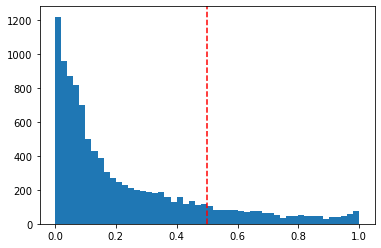

In [23]:
plt.hist(abs(diff1),bins=50)
plt.axvline(0.5,color='r',linestyle='--')
plt.show()

#### without matching

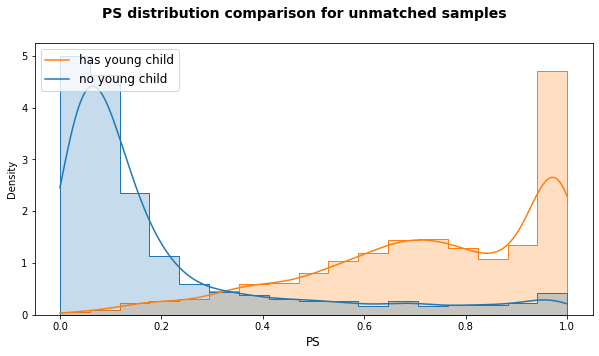

In [24]:
# Plot PS for unmatched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_05, x="PS", hue='bool0_5', kde=True, element='step', stat='density',
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

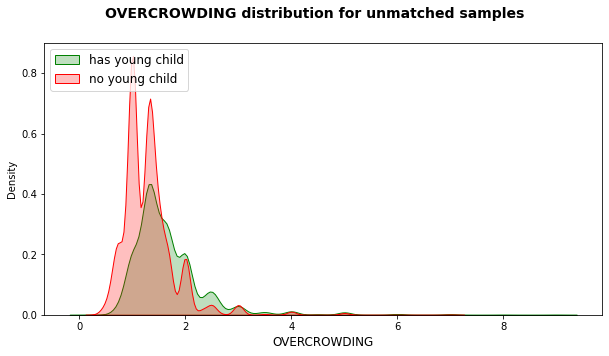

In [25]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for unmatched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_05, x=var, hue='bool0_5', palette=['r','g'], shade=True)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

In [26]:
umh = df_05.groupby('bool0_5').mean()
print('Diff of mean = ' +str(umh['UMH2'][1] - umh['UMH2'][0]))

Diff of mean = 0.33463754407085844


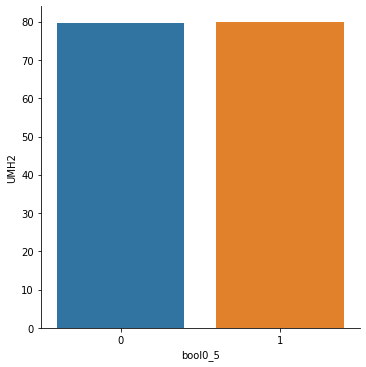

In [27]:
# not huge difference of about 0.33 -> could finish the conclusion by making bootstrap interval -> probably significant
sns.catplot(data=umh.reset_index(),x='bool0_5',y='UMH2',kind='bar')

#### with matching

In [28]:
# Performs caliper matching with caliper width 'epsilon' between treated subjects and non-treated subjects
# returns two lists with indices of matched pairs in 'treatment' and 'control' dataframes
def caliper_matching (treatment, control, epsilon) :
#    matched_pairs = []
    
    # List of control index
    idx = []
    for k in range(control.shape[0]):
        idx.append(k)
    
    # Lists of indices of treated and non-treated matched subjects
    matched_treatment_indices = []
    matched_control_indices = []
    # 1-to-1 matching
    for i in range(treatment.shape[0]) :
        for j in idx :
            diff = abs(control.loc[j,'PS'] - treatment.loc[i,'PS'])
            if diff < epsilon :
                matched_treatment_indices.append(i)
                matched_control_indices.append(j)
                idx.remove(j)
                break
    
    return matched_treatment_indices, matched_control_indices

In [29]:
trtm0_5 = df_05[df_05.bool0_5 == 1].sample(frac=1).reset_index(drop=True)
ctrl0_5 = df_05[df_05.bool0_5 == 0].sample(frac=1).reset_index(drop=True)

# Perform matching between treated and non-treated papers
epsilon=0.3
tr_match_idx, ctl_match_idx = caliper_matching(trtm0_5,ctrl0_5,epsilon)

print(f'Number of treated subjects (children) : {trtm0_5.shape[0]} \n\
Number of control subjects (no children) : {ctrl0_5.shape[0]} \n\
Number of matched pairs : {len(tr_match_idx)}')

Number of treated subjects (children) : 4411 
Number of control subjects (no children) : 6090 
Number of matched pairs : 2269


In [30]:
matched0_5 = trtm0_5.loc[tr_match_idx,:].append(ctrl0_5.loc[ctl_match_idx,:])

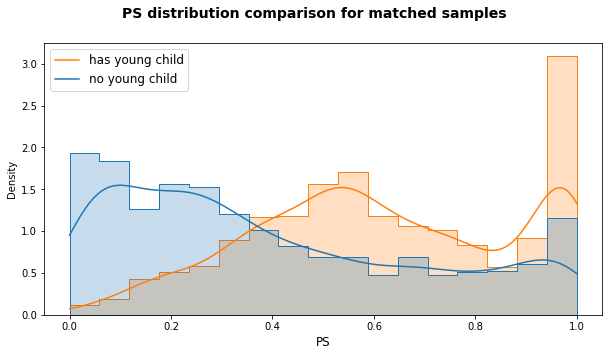

In [31]:
# Plot PS for matched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=matched0_5, x="PS", hue='bool0_5', kde=True, element='step', stat='density',
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for matched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

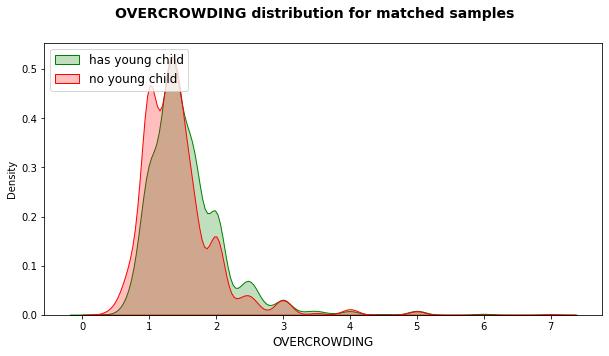

In [32]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for matched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=matched0_5, x=var, hue='bool0_5', palette=['r','g'], shade=True)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for matched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

In [33]:
# similar curves with matching !

In [34]:
umh = matched0_5.groupby('bool0_5').mean()
print('Diff of mean = ' +str(umh['UMH2'][1] - umh['UMH2'][0]))

Diff of mean = 0.49140590568532616


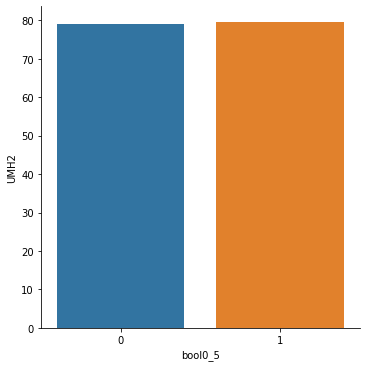

In [35]:
# not huge difference of about 0.266 -> could finish the conclusion by making bootstrap interval -> probably significant
sns.catplot(data=umh.reset_index(),x='bool0_5',y='UMH2',kind='bar')

## Linear regression models

In [36]:
# returns a regression of the 'predictors' on the 'outcome', using only subjects in 'df' that answered
# to all the outcome and predictor questions
def res_NN(df,outcome,predictors):
    
    # df without rows containing NaNs for the outcome & predictors
    df_reg = df_NN(df,outcome,predictors)
    
    # model description
    model = outcome+' ~ '
    for i in range (0,len(predictors)):
        model = model+predictors[i]
        if i != len(predictors)-1 :    # if not last
            model = model+'+'
    
    # model fit, cluster std based on state        
    return smf.ols(formula=model, data=df_reg).fit(cov_type='cluster',cov_kwds={'groups': df_reg['STATE']})

## Education

In [37]:
outcome = 'UENG'
predictors = family+income+housing_hh+['SEX','UAGE','UACT','CSPECED']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     1385.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           1.19e-58
Time:                        13:21:20   Log-Likelihood:                -48861.
No. Observations:               21077   AIC:                         9.775e+04
Df Residuals:                   21064   BIC:                         9.785e+04
Df Model:                          12                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.0595      0.276     18.324   

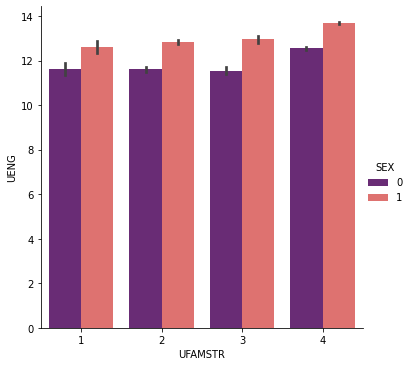

In [38]:
sns.catplot(y='UENG', x='UFAMSTR', hue='SEX', kind='bar', palette='magma', data=df_NN(fc23,outcome,predictors))

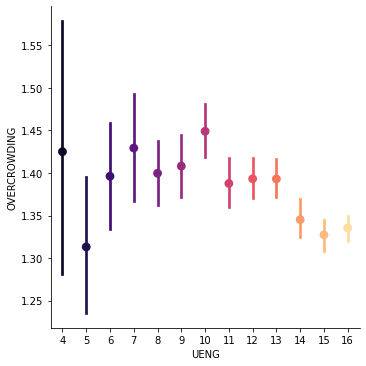

In [39]:
sns.catplot(x='UENG', y='OVERCROWDING',kind='point', palette='magma', data=df_NN(fc23,outcome,predictors))

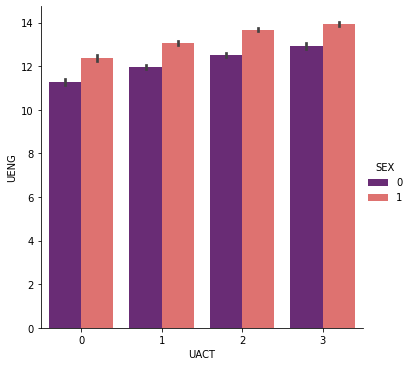

In [40]:
sns.catplot(y='UENG', x='UACT', hue='SEX', kind='bar', palette='magma', data=df_NN(fc23,outcome,predictors))

## Health

In [41]:
outcome = 'BHLTHN'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     258.4
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           4.85e-40
Time:                        13:21:23   Log-Likelihood:                -26914.
No. Observations:               21461   AIC:                         5.385e+04
Df Residuals:                   21449   BIC:                         5.395e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.2293      0.086     37.575   

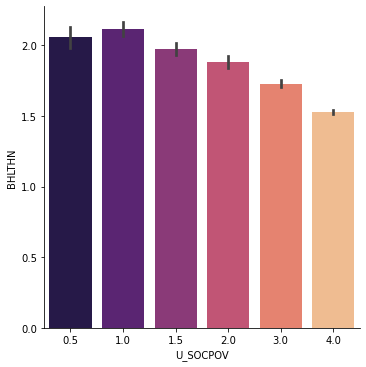

In [42]:
sns.catplot(y='BHLTHN', x='U_SOCPOV',kind='bar',palette='magma', data=df_NN(fc23,outcome,predictors))

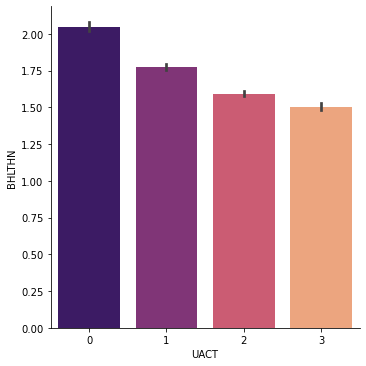

In [43]:
sns.catplot(y='BHLTHN', x='UACT',kind='bar', palette='magma', data=df_NN(fc23,outcome,predictors))

## Mental health


**fc2**


In [44]:
outcome = 'UBPIA'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     598.6
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           4.88e-49
Time:                        13:21:25   Log-Likelihood:                -21285.
No. Observations:               10583   AIC:                         4.259e+04
Df Residuals:                   10571   BIC:                         4.268e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.7844      0.220     35.364   

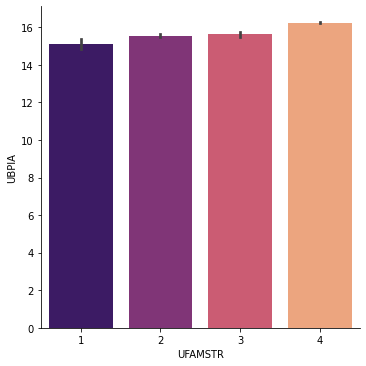

In [45]:
sns.catplot(y='UBPIA', x='UFAMSTR', kind='bar', palette='magma', data=df_NN(fc2,outcome,predictors))

**fc3**

In [46]:
outcome = 'UBPIB'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc3,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIB   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     668.4
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           3.16e-50
Time:                        13:21:25   Log-Likelihood:                -21992.
No. Observations:               10784   AIC:                         4.401e+04
Df Residuals:                   10772   BIC:                         4.410e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.7996      0.329     17.615   

In [47]:
df_noNull = df_NN(fc3,outcome, predictors)
xtest = df_noNull[predictors]
diff = (res.predict(xtest) - df_noNull['UBPIB'])
print(diff.mean(),diff.std())
#error is normally distributed -> good, but the low r squared gives a rather high std

-6.4020664799823936e-15 1.859725625210495


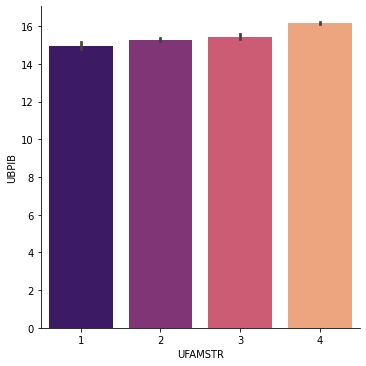

In [48]:
sns.catplot(y='UBPIB', x='UFAMSTR', kind='bar', palette='magma', data=df_NN(fc3,outcome,predictors))

## Conclusion Q1

Looking at the whole model, we can say that mental health is most influenced by housing conditions.

## Mental health of UMH2

In [49]:
outcome = 'UMH2'
predictors = family_hh+income+housing_hh
res = res_NN(child,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     44.53
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           2.55e-19
Time:                        13:21:26   Log-Likelihood:            -1.3349e+05
No. Observations:               33553   AIC:                         2.670e+05
Df Residuals:                   33545   BIC:                         2.671e+05
Df Model:                           7                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       72.4220      0.783     92.483   

In [50]:
outcome = 'UENGNEG'
predictors = ['UFAMSTR']
df_noNull = df_NN(fc23,outcome, predictors)

<AxesSubplot:xlabel='UFAMSTR', ylabel='Probability'>

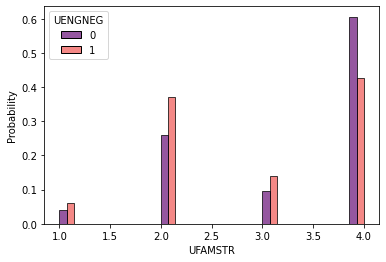

In [51]:
sns.histplot(x='UFAMSTR', hue='UENGNEG', stat='probability', data=df_noNull, common_norm=False,
             multiple='dodge', palette='magma')
# dans quelles familles sont distribués les gars mauvais